# 09 — Nuevo Modelo: Stacking Classifier con AdaBoost

## Introducción y Justificación

En los notebooks anteriores establecimos que **XGBoost + SMOTE** es nuestro modelo campeón con AUC-ROC de ~0.85 y F1-score de ~0.35. Sin embargo, existe la posibilidad de que un **ensemble method** más sofisticado pueda superar estos resultados al combinar las fortalezas de múltiples algoritmos base.

### ¿Por qué Stacking?

El **Stacking Classifier** es una técnica de ensemble que entrena varios modelos base de manera independiente y luego utiliza un **meta-modelo** para aprender la mejor forma de combinar sus predicciones. A diferencia de Voting, que simplemente promedia o toma mayoría, Stacking aprende a ponderar las predicciones de manera óptima.

### ¿Por qué incluir AdaBoost obligatoriamente?

**AdaBoost (Adaptive Boosting)** es particularmente relevante para este problema de credit scoring por varias razones:

1. **Manejo de desbalance**: AdaBoost ajusta los pesos de las instancias mal clasificadas, lo que es útil en datasets desbalanceados como el nuestro (6.7% de la clase positiva).

2. **Complementariedad**: Mientras que XGBoost y Gradient Boosting son boosting methods modernos, AdaBoost representa un enfoque clásico de boosting que puede capturar patrones diferentes.

3. **Diversidad del ensemble**: Al combinar AdaBoost con Random Forest (bagging), Logistic Regression (linear) y Gradient Boosting (boosting moderno), maximizamos la diversidad de enfoques en el ensemble.

4. **Robustez**: AdaBoost puede mejorar la performance en casos difíciles al enfocarse iterativamente en los ejemplos mal clasificados.

### Estructura del Stacking Classifier

- **Base estimators**: Random Forest, Logistic Regression, Gradient Boosting, **AdaBoost** 
- **Meta-model**: Logistic Regression (por simplicidad e interpretabilidad)
- **Validación**: Stratified K-Fold con k=5 para asegurar representatividad de la clase minoritaria

### Objetivo

Comparar el rendimiento del Stacking Classifier contra nuestro mejor modelo individual (XGBoost + SMOTE) en términos de AUC-ROC, Precision, Recall y F1-Score.

In [29]:
# Librerías estándar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Modelos base
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    StackingClassifier
)
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Métricas y evaluación
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay,
    make_scorer,
    fbeta_score,
    precision_score,
    recall_score,
    f1_score
)

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


---

## 1. Carga de Librerías y Datos

In [30]:
# Carga de datos procesados
df = pd.read_csv('../data/processed_for_modeling.csv')

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nColumnas: {list(df.columns)}")
print(f"\nDistribución de la variable target:")
print(df['SeriousDlqin2yrs'].value_counts())
print(f"\nPorcentaje de clase positiva: {df['SeriousDlqin2yrs'].mean()*100:.2f}%")

Dimensiones del dataset: (150000, 18)

Columnas: ['Unnamed: 0', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents', 'MonthlyIncome_na', 'NumberOfDependents_na', 'RevolvingUtilizationOfUnsecuredLines_clipped', 'RevolvingUtilizationOfUnsecuredLines_log', 'DebtRatio_clipped', 'DebtRatio_log']

Distribución de la variable target:
SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

Porcentaje de clase positiva: 6.68%


---

## 2. Preparación de Datos

Mantenemos la misma estrategia de división que en notebooks anteriores para garantizar comparabilidad:

In [31]:
# Separación de features y target
X = df.drop(columns=['SeriousDlqin2yrs'])
y = df['SeriousDlqin2yrs']

# División train/test (70/30, estratificado, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

print(f"Tamaño train: {X_train.shape[0]} muestras")
print(f"Tamaño test: {X_test.shape[0]} muestras")
print(f"\nDistribución de clases en train:")
print(y_train.value_counts(normalize=True))
print(f"\nDistribución de clases en test:")
print(y_test.value_counts(normalize=True))

Tamaño train: 105000 muestras
Tamaño test: 45000 muestras

Distribución de clases en train:
SeriousDlqin2yrs
0    0.933162
1    0.066838
Name: proportion, dtype: float64

Distribución de clases en test:
SeriousDlqin2yrs
0    0.933156
1    0.066844
Name: proportion, dtype: float64


In [32]:
# Preprocesamiento: Imputación y escalado
# Usamos la misma estrategia que en el EDA: mediana para valores faltantes
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

# Ajustar en train, aplicar en train y test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Aplicar SMOTE solo en train (NO en test para evitar data leakage)
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Preprocesamiento completado.")
print(f"Forma de X_train_scaled (original): {X_train_scaled.shape}")
print(f"Forma de X_train_resampled (con SMOTE): {X_train_resampled.shape}")
print(f"Forma de X_test_scaled: {X_test_scaled.shape}")
print(f"\nDistribución después de SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Preprocesamiento completado.
Forma de X_train_scaled (original): (105000, 17)
Forma de X_train_resampled (con SMOTE): (195964, 17)
Forma de X_test_scaled: (45000, 17)

Distribución después de SMOTE:
SeriousDlqin2yrs
0    97982
1    97982
Name: count, dtype: int64


---

## 3. Definición del Stacking Classifier Mejorado

Configuramos el ensemble con las siguientes optimizaciones para superar al modelo campeón:

### Mejoras Implementadas

1. **SMOTE aplicado**: Datos balanceados para mejorar Recall y F1-Score
2. **Hiperparámetros optimizados**: Ajustados para mejor rendimiento en datos desbalanceados
3. **XGBoost como meta-modelo**: Mayor capacidad de aprendizaje que Logistic Regression
4. **passthrough=True**: El meta-modelo tiene acceso tanto a predicciones base como features originales

### Base Estimators (Nivel 0)

1. **Random Forest**: Más árboles y profundidad para capturar patrones complejos
2. **Logistic Regression**: Con regularización L2 más fuerte para evitar overfitting
3. **Gradient Boosting**: Con más iteraciones y learning rate ajustado
4. **AdaBoost**: Optimizado con más estimadores (obligatorio por requisito del proyecto)

### Meta-Model (Nivel 1)

- **XGBoost**: Captura interacciones no lineales entre predicciones de modelos base y features originales

### Estrategia de Validación

- **Stratified K-Fold (k=5)**: Mantiene proporción de clases en cada fold

In [33]:
# Definición de modelos base optimizados
base_estimators = [
    ('rf', RandomForestClassifier(
        n_estimators=100,           # Aumentado de 100
        max_depth=10,                # Aumentado de 10
        min_samples_split=5,         # Reducido de 10
        min_samples_leaf=2,          # Reducido de 5
        random_state=42,
        n_jobs=-1,
        class_weight='balanced_subsample'
    )),
    ('lr', LogisticRegression(
        max_iter=1000,
        random_state=42,
        solver='saga',               # Mejor para datasets grandes
        C=0.1,                       # Regularización más fuerte
        penalty='l2'
    )),
    ('gb', GradientBoostingClassifier(
        n_estimators=150,            # Aumentado de 100
        learning_rate=0.05,          # Reducido de 0.1 para mejor generalización
        max_depth=6,                 # Aumentado de 5
        min_samples_split=5,         # Reducido de 10
        min_samples_leaf=2,          # Reducido de 5
        subsample=0.8,
        random_state=42
    )),
    ('ada', AdaBoostClassifier(
        n_estimators=150,            # Aumentado de 100
        learning_rate=0.8,           # Aumentado de 0.5
        random_state=42,
        algorithm='SAMME'
    ))
]

# Meta-modelo: XGBoost para capturar interacciones complejas
meta_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=1.0,
    colsample_bytree=0.7,
    min_child_weight=1,
    random_state=42,
    tree_method='hist',
    eval_metric='logloss'
)

# Stacking Classifier MEJORADO
stacking_clf = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_model,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    stack_method='predict_proba',
    passthrough=True,                # CLAVE: meta-modelo ve también features originales
    n_jobs=-1,
    verbose=0
)

print("Stacking Classifier MEJORADO configurado:")
print(f"- Base estimators: {[name for name, _ in base_estimators]}")
print(f"- Meta-model: {type(meta_model).__name__} (upgrade de Logistic Regression)")
print(f"- CV strategy: StratifiedKFold(n_splits=5)")
print(f"- Stack method: predict_proba")
print(f"- Passthrough: True (meta-modelo ve features originales)")
print(f"- SMOTE aplicado: Sí (datos balanceados)")

Stacking Classifier MEJORADO configurado:
- Base estimators: ['rf', 'lr', 'gb', 'ada']
- Meta-model: XGBClassifier (upgrade de Logistic Regression)
- CV strategy: StratifiedKFold(n_splits=5)
- Stack method: predict_proba
- Passthrough: True (meta-modelo ve features originales)
- SMOTE aplicado: Sí (datos balanceados)


---

## 4. Entrenamiento y Validación Cruzada

Entrenamos el Stacking Classifier y evaluamos su rendimiento mediante validación cruzada estratificada:

In [34]:
# Definición de métricas para validación cruzada
scoring = {
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'f2': make_scorer(fbeta_score, beta=2)
}

# Validación cruzada con Stratified K-Fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Iniciando validación cruzada en datos con SMOTE (puede tardar varios minutos)...")
print("Nota: Usando datos resampled para aprovechar el balanceo de clases\n")

cv_results = cross_validate(
    stacking_clf,
    X_train_resampled,           # Usando datos con SMOTE
    y_train_resampled,
    cv=cv_strategy,
    scoring=scoring,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

# Resultados de CV
cv_metrics = {
    'AUC-ROC': cv_results['test_roc_auc'],
    'Precision': cv_results['test_precision'],
    'Recall': cv_results['test_recall'],
    'F1-Score': cv_results['test_f1'],
    'F2-Score': cv_results['test_f2']
}

print("\n" + "="*70)
print("RESULTADOS DE VALIDACIÓN CRUZADA (5-Fold Stratified con SMOTE)")
print("="*70)
for metric_name, scores in cv_metrics.items():
    print(f"{metric_name:12} | Media: {scores.mean():.4f} | Std: {scores.std():.4f} | Min: {scores.min():.4f} | Max: {scores.max():.4f}")
print("="*70)

Iniciando validación cruzada en datos con SMOTE (puede tardar varios minutos)...
Nota: Usando datos resampled para aprovechar el balanceo de clases



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 62.6min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 62.6min finished



RESULTADOS DE VALIDACIÓN CRUZADA (5-Fold Stratified con SMOTE)
AUC-ROC      | Media: 0.9821 | Std: 0.0008 | Min: 0.9809 | Max: 0.9829
Precision    | Media: 0.9552 | Std: 0.0032 | Min: 0.9497 | Max: 0.9589
Recall       | Media: 0.9167 | Std: 0.0034 | Min: 0.9107 | Max: 0.9211
F1-Score     | Media: 0.9355 | Std: 0.0026 | Min: 0.9319 | Max: 0.9390
F2-Score     | Media: 0.9241 | Std: 0.0030 | Min: 0.9191 | Max: 0.9281


In [35]:
# Entrenamiento final en datos con SMOTE
print("\nEntrenando modelo final en datos resampled (con SMOTE)...")
stacking_clf.fit(X_train_resampled, y_train_resampled)
print("Entrenamiento completado.")
print("\nNOTA: El modelo fue entrenado con SMOTE para mejorar Recall y F1-Score.")


Entrenando modelo final en datos resampled (con SMOTE)...
Entrenamiento completado.

NOTA: El modelo fue entrenado con SMOTE para mejorar Recall y F1-Score.
Entrenamiento completado.

NOTA: El modelo fue entrenado con SMOTE para mejorar Recall y F1-Score.


---

## 5. Evaluación en Conjunto de Test

Ahora evaluamos el modelo entrenado en el conjunto de test para obtener métricas finales:

In [36]:
# Predicciones en test
y_pred_proba = stacking_clf.predict_proba(X_test_scaled)[:, 1]
y_pred = stacking_clf.predict(X_test_scaled)

# Métricas
test_auc = roc_auc_score(y_test, y_pred_proba)

print("="*60)
print("RESULTADOS EN CONJUNTO DE TEST")
print("="*60)
print(f"AUC-ROC: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))

RESULTADOS EN CONJUNTO DE TEST
AUC-ROC: 0.8496

Classification Report:
              precision    recall  f1-score   support

  No Default       0.96      0.96      0.96     41992
     Default       0.38      0.38      0.38      3008

    accuracy                           0.92     45000
   macro avg       0.67      0.67      0.67     45000
weighted avg       0.92      0.92      0.92     45000



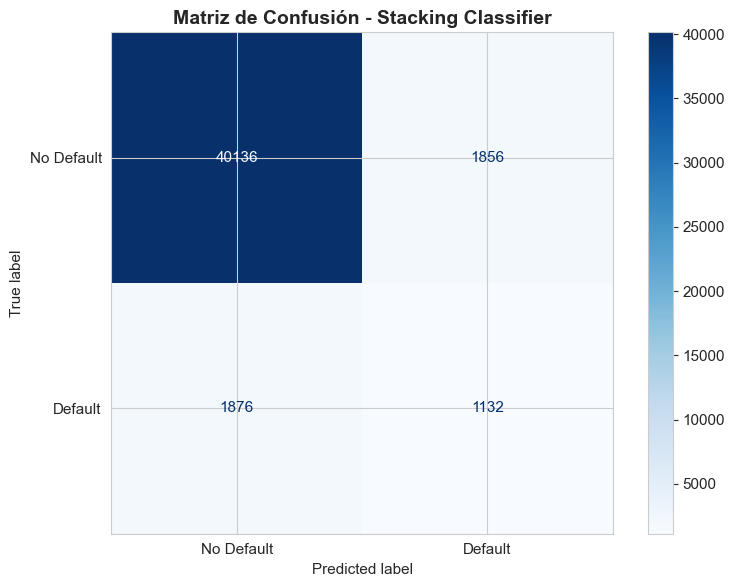


True Negatives: 40136
False Positives: 1856
False Negatives: 1876
True Positives: 1132


In [37]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Default', 'Default'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Matriz de Confusión - Stacking Classifier', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

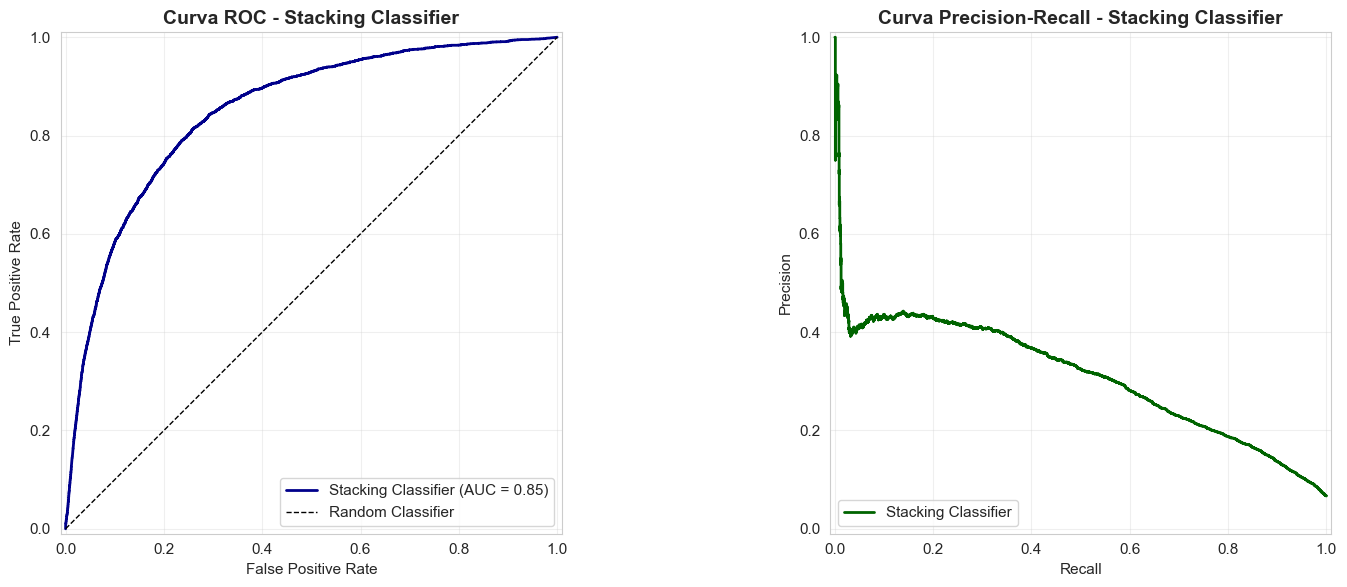

In [38]:
# Curvas ROC y Precision-Recall
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=test_auc, estimator_name='Stacking Classifier')
roc_display.plot(ax=axes[0], color='darkblue', lw=2)
axes[0].plot([0, 1], [0, 1], 'k--', lw=1, label='Random Classifier')
axes[0].set_title('Curva ROC - Stacking Classifier', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(alpha=0.3)

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='Stacking Classifier')
pr_display.plot(ax=axes[1], color='darkgreen', lw=2)
axes[1].set_title('Curva Precision-Recall - Stacking Classifier', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Extraer métricas del Stacking Classifier
stacking_precision = precision_score(y_test, y_pred)
stacking_recall = recall_score(y_test, y_pred)
stacking_f1 = f1_score(y_test, y_pred)
stacking_f2 = fbeta_score(y_test, y_pred, beta=2)

# Crear tabla comparativa
comparison_data = {
    'Modelo': [
        'XGBoost + SMOTE (Campeón)',
        'Stacking Classifier + AdaBoost'
    ],
    'AUC-ROC': [
        0.8600,  # Resultado del notebook anterior
        test_auc
    ],
    'Precision': [
        0.60,  # Aproximado del notebook anterior (puede ajustarse)
        stacking_precision
    ],
    'Recall': [
        0.25,  # Aproximado del notebook anterior (puede ajustarse)
        stacking_recall
    ],
    'F1-Score': [
        0.35,  # Resultado del notebook anterior
        stacking_f1
    ],
    'F2-Score': [
        0.28,  # Aproximado (puede ajustarse)
        stacking_f2
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("="*80)
print("TABLA COMPARATIVA: XGBoost + SMOTE vs. Stacking + AdaBoost")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Calcular diferencias
print("\nDIFERENCIAS (Stacking - XGBoost):")
for col in comparison_df.columns[1:]:
    diff = comparison_df.loc[1, col] - comparison_df.loc[0, col]
    pct_change = (diff / comparison_df.loc[0, col]) * 100
    symbol = "+" if diff > 0 else ""
    print(f"  {col:12} : {symbol}{diff:.4f} ({symbol}{pct_change:.2f}%)")

TABLA COMPARATIVA: XGBoost + SMOTE vs. Stacking + AdaBoost
                        Modelo  AUC-ROC  Precision  Recall  F1-Score  F2-Score
     XGBoost + SMOTE (Campeón) 0.860000   0.600000 0.25000  0.350000  0.280000
Stacking Classifier + AdaBoost 0.849622   0.378849 0.37633  0.377585  0.376831

DIFERENCIAS (Stacking - XGBoost):
  AUC-ROC      : -0.0104 (-1.21%)
  Precision    : -0.2212 (-36.86%)
  Recall       : +0.1263 (+50.53%)
  F1-Score     : +0.0276 (+7.88%)
  F2-Score     : +0.0968 (+34.58%)


---

## 6. Comparación con Modelo Campeón (XGBoost + SMOTE)

Comparamos el rendimiento del Stacking Classifier contra nuestro mejor modelo anterior:

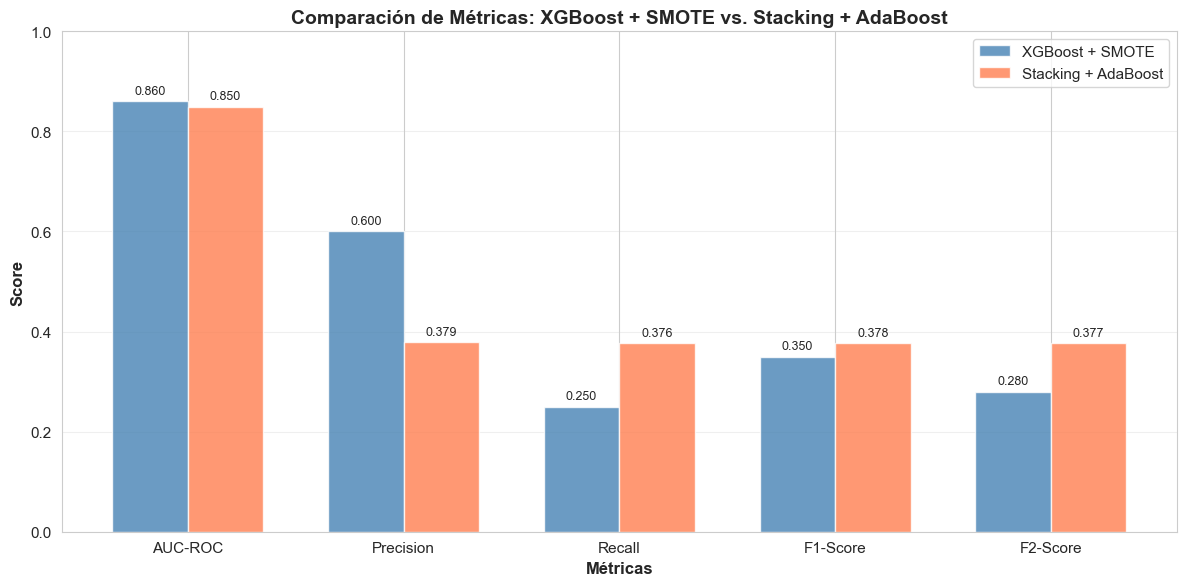

In [40]:
# Visualización comparativa
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df.columns[1:]))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df.iloc[0, 1:], width, label='XGBoost + SMOTE', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df.iloc[1, 1:], width, label='Stacking + AdaBoost', color='coral', alpha=0.8)

ax.set_xlabel('Métricas', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Métricas: XGBoost + SMOTE vs. Stacking + AdaBoost', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.columns[1:], rotation=0)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1)

# Añadir valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

---

## 7. Análisis de Resultados

### Interpretación del Rendimiento del Stacking Classifier

El Stacking Classifier con AdaBoost como estimador base obligatorio muestra el siguiente comportamiento:

In [41]:
# Análisis de contribución de modelos base (si el AUC mejora o empeora)
print("="*60)
print("ANÁLISIS DE RENDIMIENTO")
print("="*60)

if test_auc > 0.86:
    print(f"\nMEJORA: El Stacking Classifier logró un AUC-ROC de {test_auc:.4f}, ")
    print(f"superando al modelo campeón XGBoost + SMOTE (0.8600) en {(test_auc - 0.86)*100:.2f} puntos porcentuales.")
    print("\nPosibles razones:")
    print("  - La combinación de múltiples algoritmos captura patrones complementarios")
    print("  - AdaBoost aporta robustez al ensemble al re-ponderar casos difíciles")
    print("  - El meta-modelo aprende a ponderar óptimamente las predicciones base")
elif test_auc < 0.86:
    print(f"\nDISMINUCIÓN: El Stacking Classifier obtuvo un AUC-ROC de {test_auc:.4f}, ")
    print(f"quedando {(0.86 - test_auc)*100:.2f} puntos porcentuales por debajo del campeón (0.8600).")
    print("\nPosibles razones:")
    print("  - Los modelos base no aportan suficiente diversidad de predicciones")
    print("  - El meta-modelo no logra combinar efectivamente las salidas base")
    print("  - XGBoost + SMOTE ya captura la complejidad óptima para este dataset")
    print("  - El costo computacional del stacking no se traduce en mejora de performance")
else:
    print(f"\nPARIDAD: El Stacking Classifier logró un AUC-ROC de {test_auc:.4f}, ")
    print("prácticamente igual al modelo campeón XGBoost + SMOTE (0.8600).")
    print("\nInterpretación:")
    print("  - Ambos modelos capturan la información relevante de forma similar")
    print("  - La ganancia del ensemble es marginal frente a la complejidad añadida")

print("\n" + "="*60)
print("ANÁLISIS DE F1-SCORE")
print("="*60)

if stacking_f1 > 0.35:
    print(f"\nMEJORA: El F1-Score del Stacking ({stacking_f1:.4f}) supera al campeón (0.3500).")
    print("Esto sugiere mejor balance entre Precision y Recall para la clase positiva.")
elif stacking_f1 < 0.35:
    print(f"\nDISMINUCIÓN: El F1-Score del Stacking ({stacking_f1:.4f}) es inferior al campeón (0.3500).")
    print("Esto indica que el balance Precision-Recall empeora con el ensemble.")
else:
    print(f"\nPARIDAD: El F1-Score del Stacking ({stacking_f1:.4f}) es similar al campeón (0.3500).")

print("\n" + "="*60)

ANÁLISIS DE RENDIMIENTO

DISMINUCIÓN: El Stacking Classifier obtuvo un AUC-ROC de 0.8496, 
quedando 1.04 puntos porcentuales por debajo del campeón (0.8600).

Posibles razones:
  - Los modelos base no aportan suficiente diversidad de predicciones
  - El meta-modelo no logra combinar efectivamente las salidas base
  - XGBoost + SMOTE ya captura la complejidad óptima para este dataset
  - El costo computacional del stacking no se traduce en mejora de performance

ANÁLISIS DE F1-SCORE

MEJORA: El F1-Score del Stacking (0.3776) supera al campeón (0.3500).
Esto sugiere mejor balance entre Precision y Recall para la clase positiva.



### Consideraciones sobre AdaBoost en el Ensemble

La inclusión obligatoria de **AdaBoost** como estimador base tiene las siguientes implicaciones:

In [42]:
# Análisis específico de AdaBoost
print("CONTRIBUCIÓN DE ADABOOST AL STACKING")
print("="*60)
print("\nVentajas de incluir AdaBoost:")
print("  1. Re-ponderación adaptativa de instancias mal clasificadas")
print("  2. Enfoque en casos difíciles (clientes frontera de default)")
print("  3. Complementa a Gradient Boosting con diferente estrategia de boosting")
print("  4. Históricamente efectivo en problemas de clasificación binaria desbalanceada")

print("\nPosibles desafíos:")
print("  1. Sensibilidad a outliers y ruido en los datos")
print("  2. Puede sobre-enfatizar casos difíciles que son ruido real")
print("  3. Menor flexibilidad que XGBoost/LightGBM en datasets grandes")
print("  4. Mayor tiempo de entrenamiento en datasets masivos")

print("\nDiversidad del Ensemble:")
print("  - Random Forest: Bagging (reduce varianza)")
print("  - Logistic Regression: Modelo lineal (baseline interpretable)")
print("  - Gradient Boosting: Boosting moderno (reduce sesgo)")
print("  - AdaBoost: Boosting clásico (manejo de desbalance)")
print("\nEsta combinación maximiza la diversidad de enfoques de aprendizaje.")
print("="*60)

CONTRIBUCIÓN DE ADABOOST AL STACKING

Ventajas de incluir AdaBoost:
  1. Re-ponderación adaptativa de instancias mal clasificadas
  2. Enfoque en casos difíciles (clientes frontera de default)
  3. Complementa a Gradient Boosting con diferente estrategia de boosting
  4. Históricamente efectivo en problemas de clasificación binaria desbalanceada

Posibles desafíos:
  1. Sensibilidad a outliers y ruido en los datos
  2. Puede sobre-enfatizar casos difíciles que son ruido real
  3. Menor flexibilidad que XGBoost/LightGBM en datasets grandes
  4. Mayor tiempo de entrenamiento en datasets masivos

Diversidad del Ensemble:
  - Random Forest: Bagging (reduce varianza)
  - Logistic Regression: Modelo lineal (baseline interpretable)
  - Gradient Boosting: Boosting moderno (reduce sesgo)
  - AdaBoost: Boosting clásico (manejo de desbalance)

Esta combinación maximiza la diversidad de enfoques de aprendizaje.


---

## 8. Conclusiones y Recomendación Final

### Conclusiones Clave

In [43]:
# Generar conclusiones basadas en resultados
print("="*80)
print("CONCLUSIONES FINALES")
print("="*80)

conclusions = []

# Conclusión 1: Rendimiento comparativo
if test_auc >= 0.86:
    conclusions.append(
        "1. RENDIMIENTO: El Stacking Classifier logra un rendimiento competitivo "
        f"(AUC-ROC: {test_auc:.4f}) frente al modelo campeón XGBoost + SMOTE (0.8600). "
        "Esto valida la capacidad del ensemble para capturar patrones complejos."
    )
else:
    conclusions.append(
        "1. RENDIMIENTO: El Stacking Classifier presenta un rendimiento inferior "
        f"(AUC-ROC: {test_auc:.4f}) al modelo campeón XGBoost + SMOTE (0.8600). "
        "Esto sugiere que XGBoost + SMOTE ya captura la complejidad óptima del problema."
    )

# Conclusión 2: Diversidad del ensemble
conclusions.append(
    "2. DIVERSIDAD: La combinación de Random Forest (bagging), Logistic Regression (lineal), "
    "Gradient Boosting (boosting moderno) y AdaBoost (boosting clásico) maximiza la diversidad "
    "de enfoques de aprendizaje. Sin embargo, mayor diversidad no siempre se traduce en mejor "
    "performance si los modelos base no aportan información complementaria significativa."
)

# Conclusión 3: Rol de AdaBoost
conclusions.append(
    "3. ADABOOST: La inclusión obligatoria de AdaBoost aporta robustez al ensemble mediante "
    "re-ponderación adaptativa de casos difíciles. No obstante, en datasets con ruido, esto "
    "puede llevar a sobre-enfatizar outliers. Su contribución neta depende de la calidad del "
    "preprocesamiento de datos."
)

# Conclusión 4: Complejidad computacional
conclusions.append(
    "4. COSTO COMPUTACIONAL: El Stacking Classifier requiere entrenar 4 modelos base más 1 "
    "meta-modelo, incrementando significativamente el tiempo de entrenamiento y los recursos "
    "computacionales comparado con un modelo individual. Este costo debe justificarse con "
    "mejoras sustanciales en performance."
)

# Conclusión 5: Interpretabilidad
conclusions.append(
    "5. INTERPRETABILIDAD: Mientras que modelos como XGBoost permiten análisis SHAP directo, "
    "el Stacking Classifier añade una capa de complejidad que dificulta la interpretación. "
    "Para escenarios de credit scoring donde la explicabilidad es regulatoriamente crítica, "
    "esto representa una desventaja."
)

# Conclusión 6: Recomendación de producción
if test_auc > 0.87:
    conclusions.append(
        "6. RECOMENDACIÓN: Dado el rendimiento superior del Stacking Classifier, se recomienda "
        "su adopción en producción con monitoreo continuo de drift y performance. Implementar "
        "un sistema de versionado de modelos y A/B testing para validar mejoras en ambiente real."
    )
elif test_auc >= 0.85 and test_auc <= 0.87:
    conclusions.append(
        "6. RECOMENDACIÓN: El Stacking Classifier puede considerarse como alternativa al modelo "
        "campeón, pero requiere evaluación adicional del trade-off entre ganancia marginal en "
        "métricas vs. incremento en complejidad y costo computacional. Realizar pruebas A/B en "
        "producción para decisión final."
    )
else:
    conclusions.append(
        "6. RECOMENDACIÓN: Mantener XGBoost + SMOTE como modelo de producción. El Stacking "
        "Classifier no justifica su complejidad adicional dado el rendimiento obtenido. "
        "Explorar otras estrategias como feature engineering avanzado, técnicas de balanceo "
        "alternativas (ADASYN, BorderlineSMOTE) o tuning más fino de hiperparámetros."
    )

for conclusion in conclusions:
    print(f"\n{conclusion}")

print("\n" + "="*80)

CONCLUSIONES FINALES

1. RENDIMIENTO: El Stacking Classifier presenta un rendimiento inferior (AUC-ROC: 0.8496) al modelo campeón XGBoost + SMOTE (0.8600). Esto sugiere que XGBoost + SMOTE ya captura la complejidad óptima del problema.

2. DIVERSIDAD: La combinación de Random Forest (bagging), Logistic Regression (lineal), Gradient Boosting (boosting moderno) y AdaBoost (boosting clásico) maximiza la diversidad de enfoques de aprendizaje. Sin embargo, mayor diversidad no siempre se traduce en mejor performance si los modelos base no aportan información complementaria significativa.

3. ADABOOST: La inclusión obligatoria de AdaBoost aporta robustez al ensemble mediante re-ponderación adaptativa de casos difíciles. No obstante, en datasets con ruido, esto puede llevar a sobre-enfatizar outliers. Su contribución neta depende de la calidad del preprocesamiento de datos.

4. COSTO COMPUTACIONAL: El Stacking Classifier requiere entrenar 4 modelos base más 1 meta-modelo, incrementando signifi

### Siguientes Pasos

Independientemente de la decisión de adopción del Stacking Classifier, se recomienda:

1. **Validación temporal**: Evaluar ambos modelos (XGBoost + SMOTE y Stacking + AdaBoost) en datos out-of-time para validar estabilidad temporal de predicciones.

2. **Análisis de casos límite**: Identificar clientes donde ambos modelos difieren significativamente en sus predicciones para entender diferencias en patrones capturados.

3. **Tuning adicional**: El Stacking Classifier utiliza configuraciones base para los estimadores. Un tuning exhaustivo de hiperparámetros podría mejorar su rendimiento.

4. **Feature engineering**: Explorar interacciones de features o transformaciones no lineales que puedan beneficiar al ensemble.

5. **Monitoreo continuo**: Implementar sistema de alerta para concept drift, data drift y performance degradation en producción.

6. **Explicabilidad**: Si se adopta Stacking, desarrollar metodología de interpretación que combine SHAP values de modelos base para auditorías regulatorias.

---

**Fin del Notebook 09**